## NRLMSISE Atmospheric Model Plotting

This tutorial will show how to obtain atmospheric density values using the NRLMSISE00 model and plot them for the Earth.

In [14]:
import math
import numpy as np

import plotly.graph_objs as go

from ostk.physics.units import Length
from ostk.physics.units import Angle
from ostk.physics.time import Scale
from ostk.physics.time import Instant
from ostk.physics.time import DateTime
from ostk.physics.time import Duration
from ostk.physics.coordinate.spherical import LLA

from ostk.physics.environment.atmospheric import Earth

from ostk.physics import Environment

environment = Environment.default()
earth = environment.access_celestial_object_with_name("Earth")

Create the atmospheric model

In [ ]:
atmos_model = Earth(Earth.Type.NRLMSISE00)

then obtaining an atmospheric density reading is easy

In [97]:
instant = Instant.date_time(DateTime(2023, 1, 1), Scale.UTC)
lla = LLA(Angle.degrees(35.0759), Angle.degrees(-92.5451), Length.kilometers(500.0))
density_reading = atmos_model.get_density_at(lla, instant)

print(
    f"The atmospheric density at {lla.to_string()} and {instant.to_string()} is {density_reading} according to our friends at the Naval Research Lab."
)

The atmospheric density at [35.075899999999997 [deg], -92.545100000000005 [deg], 500000.0 [m]] and 2023-01-01 00:00:00 [UTC] is 1.1562210149815865e-12 according to our friends at the Naval Research Lab.


Create a latitude/longitude/time grid.

In [62]:
density = 0.1

longitudes = np.linspace(-180.0, +180.0, int(360 * density + 1))
latitudes = np.linspace(-90.0, +90.0, int(180 * density + 1))

start_instant = Instant.date_time(DateTime(2023, 1, 1, 0, 0, 0), Scale.UTC)

instants = [start_instant + Duration.hours(2.0 * i) for i in range(0, 50)]

Make a grid of densities

In [84]:
FIXED_ALTITUDE = 500.0  # km

densities = np.zeros(
    (
        len(instants),
        len(latitudes),
        len(longitudes),
    )
)

for k, instant in enumerate(instants):
    for j, lat in enumerate(latitudes):
        for i, lon in enumerate(longitudes):
            lla = LLA(
                Angle.degrees(lat),
                Angle.degrees(lon),
                Length.kilometers(FIXED_ALTITUDE),
            )

            # Call the density function
            densities[k][j][i] = atmos_model.get_density_at(lla, instant)

### The rest is just plotting!

In [64]:
def map_to_sphere(lon, lat, radius=1):
    """
    Maps points of coords (lon, lat) to points onto a sphere
    """

    deg2rad = lambda deg: deg * np.pi / 180.0

    lon = np.array(lon, dtype=np.float64)
    lat = np.array(lat, dtype=np.float64)

    lon = deg2rad(lon)
    lat = deg2rad(lat)

    xs = radius * np.cos(lon) * np.cos(lat)
    ys = radius * np.sin(lon) * np.cos(lat)
    zs = radius * np.sin(lat)

    return (xs, ys, zs)

In [65]:
(XS, YS, ZS) = map_to_sphere(*np.meshgrid(longitudes, latitudes))

In [66]:
colorscale = [
    [0.0, "#313695"],
    [0.07692307692307693, "#3a67af"],
    [0.15384615384615385, "#5994c5"],
    [0.23076923076923078, "#84bbd8"],
    [0.3076923076923077, "#afdbea"],
    [0.38461538461538464, "#d8eff5"],
    [0.46153846153846156, "#d6ffe1"],
    [0.5384615384615384, "#fef4ac"],
    [0.6153846153846154, "#fed987"],
    [0.6923076923076923, "#fdb264"],
    [0.7692307692307693, "#f78249"],
    [0.8461538461538461, "#e75435"],
    [0.9230769230769231, "#cc2727"],
    [1.0, "#a50026"],
]

noaxis = dict(
    showbackground=False,
    showgrid=False,
    showline=False,
    showticklabels=False,
    ticks="",
    title="",
    zeroline=False,
)

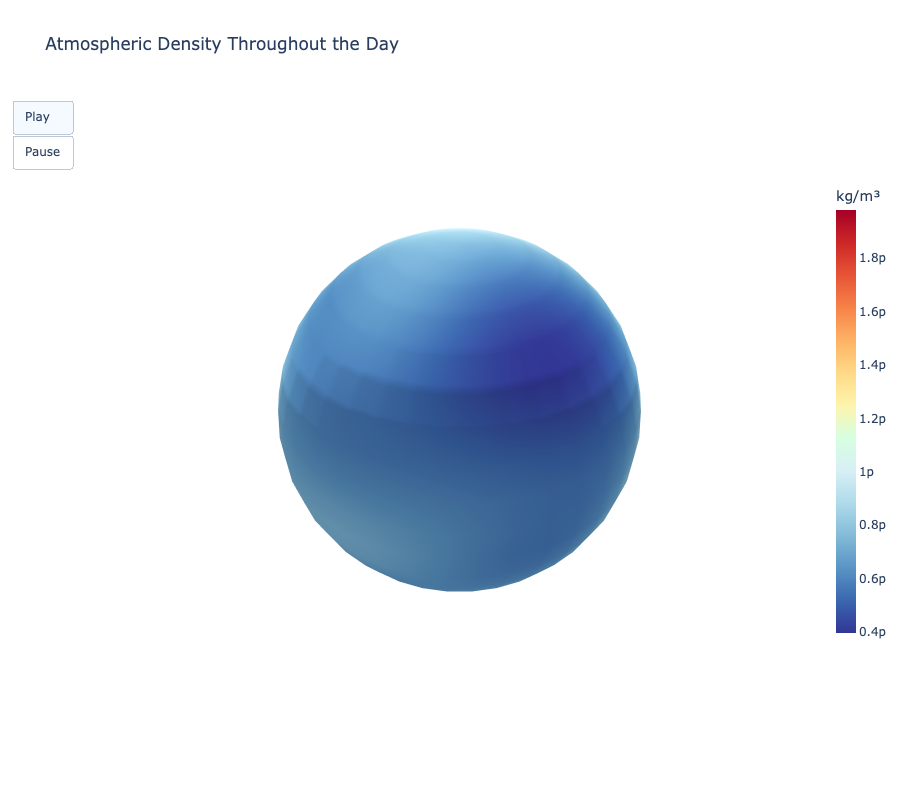

In [85]:
plot_objects = [
    [
        go.Surface(
            x=XS,
            y=YS,
            z=ZS,
            surfacecolor=densities[i, :, :],
            colorscale=colorscale,
            cmin=np.min(densities[i, :, :]),
            cmax=np.max(densities[i, :, :]),
            colorbar=go.surface.ColorBar(
                title="kg/m³", thickness=20, len=0.75, ticklen=4
            ),
            text=f"time of day: {instant.to_string()}",
        )
    ]
    for i, instant in enumerate(instants)
]

figure = go.Figure(
    data=[*plot_objects[0]],
    layout=go.Layout(
        title="Atmospheric Density Throughout the Day",
        width=800,
        height=800,
        scene=go.layout.Scene(
            xaxis=noaxis,
            yaxis=noaxis,
            zaxis=noaxis,
            aspectratio=go.layout.scene.Aspectratio(x=1, y=1, z=1),
            camera=dict(eye=dict(x=1.15, y=1.15, z=1.15)),
        ),
        updatemenus=[
            dict(
                type="buttons",
                buttons=[
                    dict(label="Play", method="animate", args=[None]),
                    dict(
                        label="Pause",
                        method="animate",
                        args=[
                            None,
                            {
                                "frame": {"duration": 0, "redraw": False},
                                "mode": "immediate",
                                "transition": {"duration": 0},
                            },
                        ],
                    ),
                ],
            )
        ],
    ),
    frames=[go.Frame(data=[*plot_obj]) for plot_obj in plot_objects],
)

figure.show()